# Precision-recall evaluation on MNIST
Deterministic NN vs Bayesian NN with Gaussian posterior

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [150]:
torch.ones(10,5)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [168]:
a= torch.Tensor([[1,2,3],[4,5,6]])

In [169]:
a

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [184]:
b = torch.Tensor([0,0,1])

In [186]:
c = b.type(torch.long)

In [187]:
torch.gather(a, 0, c.view(1,-1))

tensor([[1., 2., 6.]])

In [149]:
torch.distributions.Normal(0,1).sample(torch.zeros(10,5).shape)

tensor([[ 1.8311,  0.1458,  2.0655, -0.4303,  1.2895],
        [ 1.4148, -0.5620, -0.3313,  0.9851, -1.3295],
        [-0.6995, -2.2081,  0.4201,  0.2110,  1.7627],
        [ 1.3140, -0.4039,  1.2590,  1.0897, -0.2447],
        [ 0.9169, -0.0683, -0.6836,  1.2091, -0.3573],
        [-0.7761, -0.9458, -0.2724, -0.4928, -0.0967],
        [-0.2763,  0.2776,  0.3435,  0.5475, -2.1465],
        [ 0.6272, -0.5613,  2.1313, -1.0119, -0.8237],
        [ 0.0293,  1.3530,  1.9810,  1.2320, -0.7161],
        [-0.4561,  0.2082, -0.0090,  1.0315, -0.2779]])

In [106]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, mu1, mu2, sigma1, sigma2, device):
        super().__init__()
        self.pi = pi
        self.sigma1 = torch.FloatTensor([np.exp(-sigma1)]).to(device)
        self.sigma2 = torch.FloatTensor([np.exp(-sigma2)]).to(device)
        print (self.sigma1)
        print (self.sigma2)
        self.gaussian1 = torch.distributions.Normal(mu1,self.sigma1)
        self.gaussian2 = torch.distributions.Normal(mu2,self.sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)) #.sum()

In [117]:
class Gaussian(object):
    def __init__(self, mu, rho, device):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
        self.device=device
    
    @property
    def sigma(self):
        if self.rho.sum()==0:
            return torch.ones_like(self.rho)
        else:
            return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        print (self.sigma)
        epsilon = self.normal.sample(self.rho.size()).to(self.device)
        print (epsilon)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        print (self.sigma)
        return (-np.log(np.sqrt(2 * np.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)) #.sum()


In [124]:
class GaussianPrior(object):
    def __init__(self, mu, rho, device):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.device=device
        
    def log_prob(self, input):
        print (self.rho)
        return (-np.log(np.sqrt(2 * np.pi))
                - torch.log(self.rho)
                - ((input - self.mu) ** 2) / (2 * self.rho ** 2)) #.sum()


In [119]:
ScaleMixtureGaussian(0.5, 0, 0, 0, 6, device=device).log_prob(torch.ones(10,5).to(device))

tensor([1.], device='cuda:0')
tensor([0.0025], device='cuda:0')


tensor([[-2.1121, -2.1121, -2.1121, -2.1121, -2.1121],
        [-2.1121, -2.1121, -2.1121, -2.1121, -2.1121],
        [-2.1121, -2.1121, -2.1121, -2.1121, -2.1121],
        [-2.1121, -2.1121, -2.1121, -2.1121, -2.1121],
        [-2.1121, -2.1121, -2.1121, -2.1121, -2.1121],
        [-2.1121, -2.1121, -2.1121, -2.1121, -2.1121],
        [-2.1121, -2.1121, -2.1121, -2.1121, -2.1121],
        [-2.1121, -2.1121, -2.1121, -2.1121, -2.1121],
        [-2.1121, -2.1121, -2.1121, -2.1121, -2.1121],
        [-2.1121, -2.1121, -2.1121, -2.1121, -2.1121]], device='cuda:0')

In [120]:
Gaussian(torch.zeros(10,5),torch.zeros(10,5),device).log_prob(torch.ones(10,5))

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


tensor([[-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189]])

In [132]:
GaussianPrior(torch.zeros(10,5),torch.ones(10,5),device).log_prob(torch.ones(10,5))

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


tensor([[-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189],
        [-1.4189, -1.4189, -1.4189, -1.4189, -1.4189]])

In [134]:
torch.log1p(torch.exp(torch.Tensor([0])))

tensor([0.6931])

In [138]:
torch.distributions.Normal(0,1).sample()

tensor(0.6150)

In [141]:
torch.nn.Softplus()(torch.Tensor([0]))

tensor([0.6931])

In [122]:
Gaussian(torch.zeros(10,5),24*torch.eye(10,5),device).log_prob(torch.ones(10,5))

tensor([[24.0000,  0.6931,  0.6931,  0.6931,  0.6931],
        [ 0.6931, 24.0000,  0.6931,  0.6931,  0.6931],
        [ 0.6931,  0.6931, 24.0000,  0.6931,  0.6931],
        [ 0.6931,  0.6931,  0.6931, 24.0000,  0.6931],
        [ 0.6931,  0.6931,  0.6931,  0.6931, 24.0000],
        [ 0.6931,  0.6931,  0.6931,  0.6931,  0.6931],
        [ 0.6931,  0.6931,  0.6931,  0.6931,  0.6931],
        [ 0.6931,  0.6931,  0.6931,  0.6931,  0.6931],
        [ 0.6931,  0.6931,  0.6931,  0.6931,  0.6931],
        [ 0.6931,  0.6931,  0.6931,  0.6931,  0.6931]])


tensor([[-4.0979, -1.5931, -1.5931, -1.5931, -1.5931],
        [-1.5931, -4.0979, -1.5931, -1.5931, -1.5931],
        [-1.5931, -1.5931, -4.0979, -1.5931, -1.5931],
        [-1.5931, -1.5931, -1.5931, -4.0979, -1.5931],
        [-1.5931, -1.5931, -1.5931, -1.5931, -4.0979],
        [-1.5931, -1.5931, -1.5931, -1.5931, -1.5931],
        [-1.5931, -1.5931, -1.5931, -1.5931, -1.5931],
        [-1.5931, -1.5931, -1.5931, -1.5931, -1.5931],
        [-1.5931, -1.5931, -1.5931, -1.5931, -1.5931],
        [-1.5931, -1.5931, -1.5931, -1.5931, -1.5931]])

In [123]:
GaussianPrior(torch.zeros(10,5),24*torch.eye(10,5),device).log_prob(torch.ones(10,5))

tensor([[24.,  0.,  0.,  0.,  0.],
        [ 0., 24.,  0.,  0.,  0.],
        [ 0.,  0., 24.,  0.,  0.],
        [ 0.,  0.,  0., 24.,  0.],
        [ 0.,  0.,  0.,  0., 24.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]])


tensor([[-4.0979,     nan,     nan,     nan,     nan],
        [    nan, -4.0979,     nan,     nan,     nan],
        [    nan,     nan, -4.0979,     nan,     nan],
        [    nan,     nan,     nan, -4.0979,     nan],
        [    nan,     nan,     nan,     nan, -4.0979],
        [    nan,     nan,     nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,     nan]])

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread
import math

In [3]:
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from collections import OrderedDict

In [13]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Global parameters
NUM_EPOCHS = 5
STEP = 0.1
THRESHOLDS = np.concatenate((np.arange(0,1, step=STEP),np.array([0.99])))
NUM_SAMPLES = [1, 3, 5, 10, 30, 100]

PI = 0.5
SIGMA_1 = torch.cuda.FloatTensor([np.exp(-0)])
SIGMA_2 = torch.cuda.FloatTensor([np.exp(-6)])

BATCH_SIZE = 128
CLASSES = 10
TRAIN_EPOCHS = 20
SAMPLES = 2
TEST_SAMPLES = 10

In [6]:
# Loading MNIST dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data/mnist-data/', train=True, download=True,
                   transform=transforms.Compose([transforms.ToTensor(),])),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/mnist-data/', train=False, 
                       transform=transforms.Compose([transforms.ToTensor(),])),
    batch_size=BATCH_SIZE, shuffle=True)

In [69]:
class Gaussian(object):
    def __init__(self, mu, rho, device):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
        self.device=device
    
    @property
    def sigma(self):
        if self.rho.sum()==0:
            return torch.ones_like(self.rho)
        else:
            return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(self.device)
        print (epsilon)
        print (self.sigma)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-np.log(np.sqrt(2 * np.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [7]:
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

In [70]:
Gaussian(torch.zeros(10,5).to(device),torch.zeros(10,5).to(device),device).sample()

tensor([[-0.7074,  0.0238, -0.5096,  0.4280, -0.2471],
        [ 0.6005, -1.4848,  0.2246, -0.6367, -0.0538],
        [ 0.4300,  0.7798,  0.9468,  2.8998, -0.7613],
        [ 0.3018, -2.5107,  0.5776, -1.5420,  0.2517],
        [-1.1560, -1.6205,  0.5913, -0.3128,  0.7030],
        [-0.4545, -0.4205, -0.9062,  0.3098,  1.2142],
        [ 0.7501, -0.0930, -0.7028,  0.6399,  0.4814],
        [ 0.0479, -1.4405,  0.3817,  0.2518, -1.4852],
        [ 0.2891, -1.3646,  1.1017,  0.1238,  0.2827],
        [-0.6365,  0.6707, -0.4309, -0.2197, -0.0843]], device='cuda:0')
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], device='cuda:0')


tensor([[-0.7074,  0.0238, -0.5096,  0.4280, -0.2471],
        [ 0.6005, -1.4848,  0.2246, -0.6367, -0.0538],
        [ 0.4300,  0.7798,  0.9468,  2.8998, -0.7613],
        [ 0.3018, -2.5107,  0.5776, -1.5420,  0.2517],
        [-1.1560, -1.6205,  0.5913, -0.3128,  0.7030],
        [-0.4545, -0.4205, -0.9062,  0.3098,  1.2142],
        [ 0.7501, -0.0930, -0.7028,  0.6399,  0.4814],
        [ 0.0479, -1.4405,  0.3817,  0.2518, -1.4852],
        [ 0.2891, -1.3646,  1.1017,  0.1238,  0.2827],
        [-0.6365,  0.6707, -0.4309, -0.2197, -0.0843]], device='cuda:0')

### Part 1 : Training a small Bayesian Neural Network

In [72]:
Gaussian(torch.zeros(10,5).to(device),torch.eye(10,5).to(device),device).sample()

tensor([[ 0.8938,  1.2704,  0.7868, -0.0239, -0.9429],
        [ 0.3263, -1.1971,  0.6011, -0.1440, -1.0917],
        [ 0.6155,  0.9346,  0.6669,  0.6839,  0.1167],
        [-0.0323, -0.2152,  0.3089,  0.2264, -0.7507],
        [ 0.1055,  0.9479, -1.7207,  0.6047,  0.3411],
        [ 0.8335,  0.8973, -0.7506, -0.8907, -0.0982],
        [ 0.2402,  1.7435,  0.4182,  0.7371,  0.2697],
        [-0.5172,  0.3135, -0.5919, -0.9341,  0.7163],
        [ 0.1418,  0.8340, -0.5174,  0.5734, -1.3324],
        [ 0.3684, -0.3596,  1.7246,  0.8911,  1.9378]], device='cuda:0')
tensor([[1.3133, 0.6931, 0.6931, 0.6931, 0.6931],
        [0.6931, 1.3133, 0.6931, 0.6931, 0.6931],
        [0.6931, 0.6931, 1.3133, 0.6931, 0.6931],
        [0.6931, 0.6931, 0.6931, 1.3133, 0.6931],
        [0.6931, 0.6931, 0.6931, 0.6931, 1.3133],
        [0.6931, 0.6931, 0.6931, 0.6931, 0.6931],
        [0.6931, 0.6931, 0.6931, 0.6931, 0.6931],
        [0.6931, 0.6931, 0.6931, 0.6931, 0.6931],
        [0.6931, 0.6931, 0.6931,

tensor([[ 1.1738,  0.8805,  0.5453, -0.0165, -0.6536],
        [ 0.2262, -1.5721,  0.4166, -0.0998, -0.7567],
        [ 0.4266,  0.6478,  0.8758,  0.4740,  0.0809],
        [-0.0224, -0.1491,  0.2141,  0.2973, -0.5203],
        [ 0.0731,  0.6570, -1.1927,  0.4192,  0.4479],
        [ 0.5777,  0.6220, -0.5203, -0.6174, -0.0681],
        [ 0.1665,  1.2085,  0.2899,  0.5109,  0.1869],
        [-0.3585,  0.2173, -0.4103, -0.6474,  0.4965],
        [ 0.0983,  0.5781, -0.3587,  0.3975, -0.9235],
        [ 0.2554, -0.2493,  1.1954,  0.6177,  1.3432]], device='cuda:0')

In [14]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(device)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-np.log(np.sqrt(2 * np.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [15]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

In [16]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

In [21]:
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = BayesianLinear(28*28, 400)
        self.l2 = BayesianLinear(400, 400)
        self.l3 = BayesianLinear(400, 10)
    
    def forward(self, x, sample=False):
        x = x.view(-1, 28*28)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        return x
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l2.log_variational_posterior
    
    def sample_elbo(self, input, target, samples=SAMPLES):
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES).to(device)
        log_priors = torch.zeros(samples).to(device)
        log_variational_posteriors = torch.zeros(samples).to(device)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        output = outputs.mean(0)
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(output, target, reduction='sum')
        print (log_variational_posterior)
        print (log_prior)
        print (NUM_BATCHES)
        print (negative_log_likelihood)
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        return output, loss, log_prior, log_variational_posterior, negative_log_likelihood



In [27]:
net = BayesianNetwork().to(device)
optimizer_bnn = optim.Adam(net.parameters(), lr=0.001)

In [28]:
# Training our BNN model 
for epoch in range(NUM_EPOCHS):
    net.train()
    loss, nll, acc = 0, 0, 0
    len_steps = 0
    i=0
    loop = tqdm(train_loader)
    for batch_id, (data, target) in enumerate(loop):
        data, target = data.to(device), target.to(device)
        optimizer_bnn.zero_grad()
        output, cur_loss, log_prior, log_variational_posterior, cur_nll = net.sample_elbo(data, target)
        cur_loss.backward()
        loss += cur_loss
        nll += cur_nll
        optimizer_bnn.step()
        len_steps += len(data)
        
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        acc += pred.eq(target.view_as(pred)).sum().item()
        
        #update the average loss
        loop.set_description('Epoch {}/{}'.format(epoch + 1, NUM_EPOCHS))
        loop.set_postfix(OrderedDict({'loss':'{:05.3f}'.format(loss / float(len_steps)), 
                                      'acc':'{:05.3f}'.format(acc / float(len_steps))}))
        loop.update()
        
        print (loss)
        print('-----')
        i+=1
        if i>2:
            break
    break    
    # Eval on epoch end
    net.eval()
    test_loss, test_nll, accuracy_test = 0, 0, 0 
            
    with torch.no_grad():
        for data_test, target_test in test_loader:
            data_test, target_test = data_test.to(device), target_test.to(device)
            output_test, cur_test_loss, _, _, cur_test_nll = net.sample_elbo(data_test, target_test)
            test_loss += cur_test_loss
            test_nll += cur_test_nll
            pred_test = output_test.argmax(dim=1, keepdim=True)
            accuracy_test += pred_test.eq(target_test.view_as(pred_test)).sum().item()

    print('Epoch {}/{}: train_loss={:05.4g}, train_nll={:05.4g}, train_acc={:05.3f}, test_loss={:05.4g}, test_nll={:05.3f}, test_acc={:05.3f}'
          .format(epoch, NUM_EPOCHS, loss / float(len_steps), acc / float(len_steps), nll / float(len_steps), 
                  test_loss.item() / float(len(test_loader.dataset)), accuracy_test / float(len(test_loader.dataset)), 
                  test_nll.item() / float(len(test_loader.dataset))))

tensor(1961157.7500, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(-689677.8750, device='cuda:0', grad_fn=<MeanBackward1>)
469
tensor(665.9767, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(6318.0781, device='cuda:0', grad_fn=<AddBackward0>)
-----
tensor(1959909., device='cuda:0', grad_fn=<MeanBackward1>)
tensor(-687829.0625, device='cuda:0', grad_fn=<MeanBackward1>)
469
tensor(465.1894, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(12428.7646, device='cuda:0', grad_fn=<AddBackward0>)
-----
tensor(1959892., device='cuda:0', grad_fn=<MeanBackward1>)
tensor(-685676.5000, device='cuda:0', grad_fn=<MeanBackward1>)
469
tensor(360.4101, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(18430.0469, device='cuda:0', grad_fn=<AddBackward0>)
-----


In [155]:
def predict_bnn(x, num_s):
    outputs = torch.zeros(num_s+1, x.shape[0], CLASSES).to(device)
    for i in range(num_s):
        outputs[i] = net(x, sample=True)
    outputs[num_s] = net(x, sample=False)
    output = outputs.mean(0)
    return output

### Part 2 : Training a deterministic Neural Network

In [91]:
class DeterministicNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(DeterministicNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = F.relu(self.fc1(x))
        output = F.relu(self.fc2(output))
        output = self.out(output)
        return F.log_softmax(output, dim=1)

In [92]:
deterministic_model = DeterministicNN(28*28, 1200, 10).to(device)
optimizer_deter = optim.Adam(deterministic_model.parameters(), lr=0.001)

In [93]:
summary(deterministic_model, input_size=(1,1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 1, 1, 1200]         942,000
            Linear-2           [-1, 1, 1, 1200]       1,441,200
            Linear-3             [-1, 1, 1, 10]          12,010
Total params: 2,395,210
Trainable params: 2,395,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 9.14
Estimated Total Size (MB): 9.16
----------------------------------------------------------------


In [94]:
# Training our deterministic model 
for epoch in range(NUM_EPOCHS):
    deterministic_model.train()
    loss = 0
    acc = 0
    len_steps = 0
    
    loop = tqdm(train_loader)
    for batch_id, (data, target) in enumerate(loop):
        data, target = data.to(device), target.to(device)
        optimizer_deter.zero_grad()
        output = deterministic_model(data.view(-1,28*28))
        current_loss = F.nll_loss(output, target)
        current_loss.backward()
        loss += current_loss
        optimizer_deter.step()
        len_steps += len(data)
        
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        acc += pred.eq(target.view_as(pred)).sum().item()

        #update the average loss
        loop.set_description('Epoch {}/{}'.format(epoch + 1, NUM_EPOCHS))
        loop.set_postfix(OrderedDict({'loss':'{:05.3f}'.format(loss / float(len_steps)), 
                                      'acc':'{:05.3f}'.format(acc / float(len_steps))}))
        loop.update()
        
    # Eval on epoch end
    deterministic_model.eval()
    test_loss = 0
    accuracy_test = 0
    with torch.no_grad():
        for data_test, target_test in test_loader:
            data_test, target_test = data_test.to(device), target_test.to(device)
            output_test = deterministic_model(data_test.view(-1,28*28))
            test_loss += F.nll_loss(output_test, target_test)
            pred_test = output_test.argmax(dim=1, keepdim=True)
            accuracy_test += pred_test.eq(target_test.view_as(pred_test)).sum()
    print('Epoch {}/{}: train_loss={:05.4g}, train_acc={:05.3f}, test_loss={:05.4g}, test_acc={:05.3f}'
          .format(epoch, NUM_EPOCHS, loss / float(len_steps), acc / float(len_steps), 
                  test_loss.item() / float(len(test_loader.dataset)), accuracy_test.item() / float(len(test_loader.dataset))))

Epoch 0/5: train_loss=0.002055, train_acc=0.937, test_loss=0.001014, test_acc=0.971


Epoch 1/5: train_loss=0.0008098, train_acc=0.975, test_loss=0.0008279, test_acc=0.975


Epoch 2/5: train_loss=0.0005146, train_acc=0.984, test_loss=0.0006937, test_acc=0.979


Epoch 3/5: train_loss=0.0003872, train_acc=0.987, test_loss=0.0007594, test_acc=0.978


Epoch 4/5: train_loss=0.0003232, train_acc=0.989, test_loss=0.0007727, test_acc=0.979


In [95]:
def predict_determ(x):
    output = torch.exp(deterministic_model(x))
    return output

## Part 3: plot precision-recall curves

In [96]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [97]:
def one_hot_embedding(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels] 

In [156]:
def predict_test_set(bnn=False, num_s=1, verbose=True):
    Y_test = []
    proba_pred = []
    correct = 0
    with torch.no_grad():
        loop = tqdm(test_loader, disable=not verbose)
        for j, (data,labels) in enumerate(loop):
            data, labels = data.to(device), labels.to(device)
            if bnn:
                output = predict_bnn(data, num_s)
            else:
                output = predict_determ(data.view(-1,28*28))
            Y_test.extend(labels)
            proba_pred.extend(output)
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    Y_test = one_hot_embedding(Y_test,10).numpy()
    proba_pred = torch.stack(proba_pred).to('cpu').numpy()
    
    print('Test set: Accuracy: {}/{} ({:.0f}%)'.format(
        correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    
    return Y_test, proba_pred

In [107]:
def compute_precision_recall(Y_test, proba_pred):
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(10):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                            proba_pred[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], proba_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
        proba_pred.ravel())
    average_precision["micro"] = average_precision_score(Y_test, proba_pred,
                                                         average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))

    return precision, recall, average_precision

In [108]:
Y_test_determ, proba_pred_determ = predict_test_set(bnn=False)

Test set: Accuracy: 9787/10000 (98%)


In [109]:
precision_determ, recall_determ, average_precision_determ = compute_precision_recall(Y_test_determ, proba_pred_determ)

Average precision score, micro-averaged over all classes: 1.00


In [157]:
Y_test_bnn, proba_pred_bnn = [], []
precision_bnn, recall_bnn, average_precision_bnn = [], [], []
for i,S in enumerate(NUM_SAMPLES):
    print('============================')
    print ('CHECKING FOR NUM_SAMPLES={}'.format(S))
    Y_test, proba_pred = predict_test_set(bnn=True, verbose=False)
    Y_test_bnn.append(Y_test)
    proba_pred_bnn.append(proba_pred)
    
    precision, recall, average_precision = compute_precision_recall(Y_test, proba_pred)
    precision_bnn.append(precision)
    recall_bnn.append(recall)
    average_precision_bnn.append(average_precision)

CHECKING FOR NUM_SAMPLES=1
Test set: Accuracy: 9744/10000 (97%)
Average precision score, micro-averaged over all classes: 1.00
CHECKING FOR NUM_SAMPLES=3
Test set: Accuracy: 9754/10000 (98%)
Average precision score, micro-averaged over all classes: 1.00
CHECKING FOR NUM_SAMPLES=5
Test set: Accuracy: 9747/10000 (97%)
Average precision score, micro-averaged over all classes: 1.00
CHECKING FOR NUM_SAMPLES=10
Test set: Accuracy: 9749/10000 (97%)
Average precision score, micro-averaged over all classes: 1.00
CHECKING FOR NUM_SAMPLES=30
Test set: Accuracy: 9748/10000 (97%)
Average precision score, micro-averaged over all classes: 1.00
CHECKING FOR NUM_SAMPLES=100
Test set: Accuracy: 9739/10000 (97%)
Average precision score, micro-averaged over all classes: 1.00


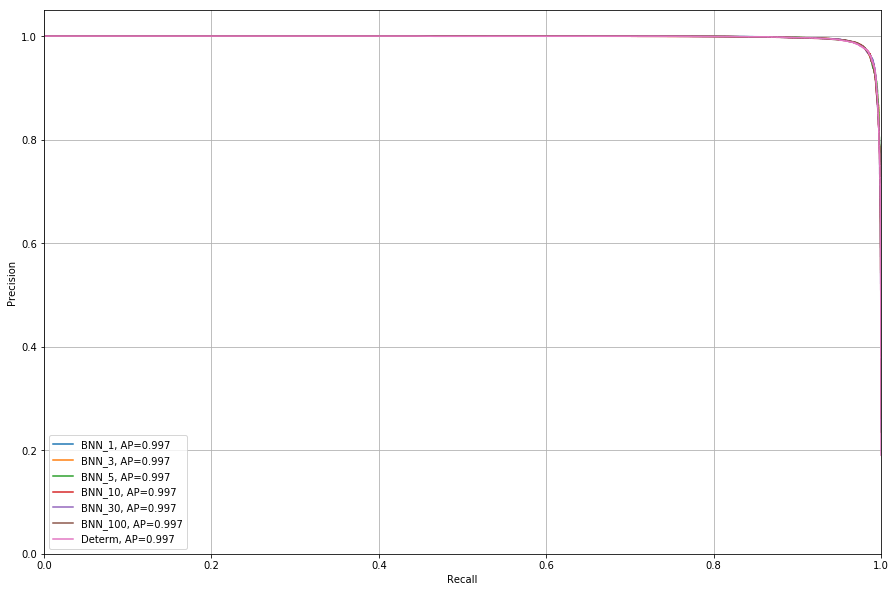

In [119]:
plt.figure(figsize=(15,10))
for i in range(len(NUM_SAMPLES)):
    plt.plot(recall_bnn[i]['micro'], precision_bnn[i]['micro'], 
             label='BNN_{}, AP={:.3f}'.format(NUM_SAMPLES[i],average_precision_bnn[i]['micro']))
plt.plot(recall_determ['micro'], precision_determ['micro'], 
         label='Determ, AP={:.3f}'.format(average_precision_determ['micro']))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()
plt.grid()
plt.show()

## Part 4: Compute ROC curve

In [122]:
def get_accuracy_threshold(Y_test, proba_pred, threshold):
    proba_above_threshold = np.max(proba_pred, axis=1)>=threshold
    correct_predictions = np.argmax(proba_pred, axis=1)==np.argmax(Y_test, axis=1)
    
    predicted_for_images = np.sum(proba_above_threshold)
    correct_predictions_above_threshold = np.sum(proba_above_threshold*correct_predictions)

    return (correct_predictions_above_threshold / predicted_for_images)

In [123]:
accuracies_determ = []
for t in THRESHOLDS:
    cur_acc = get_accuracy_threshold(Y_test_determ, proba_pred_determ, t)
    accuracies_determ.append(cur_acc)

In [124]:
accuracies_bnn = [[] for i in NUM_SAMPLES]
for i,S in enumerate(NUM_SAMPLES):
    for t in THRESHOLDS:
        cur_acc = get_accuracy_threshold(Y_test_bnn[i], proba_pred_bnn[i], t)
        accuracies_bnn[i].append(cur_acc)

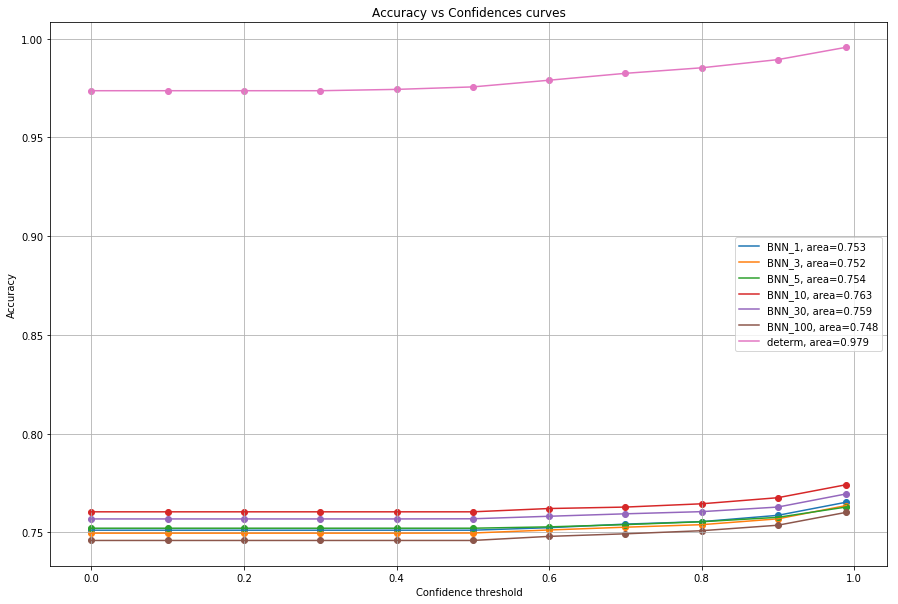

In [171]:
plt.figure(figsize=(15,10))
for i,acc in enumerate(accuracies_bnn):
    plt.scatter(THRESHOLDS, acc)
    plt.plot(THRESHOLDS, acc, label='BNN_{}, area={:.3f}'.format(NUM_SAMPLES[i], np.trapz(acc, dx=STEP)))
plt.scatter(THRESHOLDS, accuracies_determ)
plt.plot(THRESHOLDS, accuracies_determ, label='Determ, area={:.3f}'.format(np.trapz(accuracies_determ, dx=STEP)))
plt.legend()
plt.xlabel('Confidence threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Confidences curves')
plt.grid()
plt.show()

## Part 4: Compute calibration plot

In [88]:
from sklearn.calibration import calibration_curve

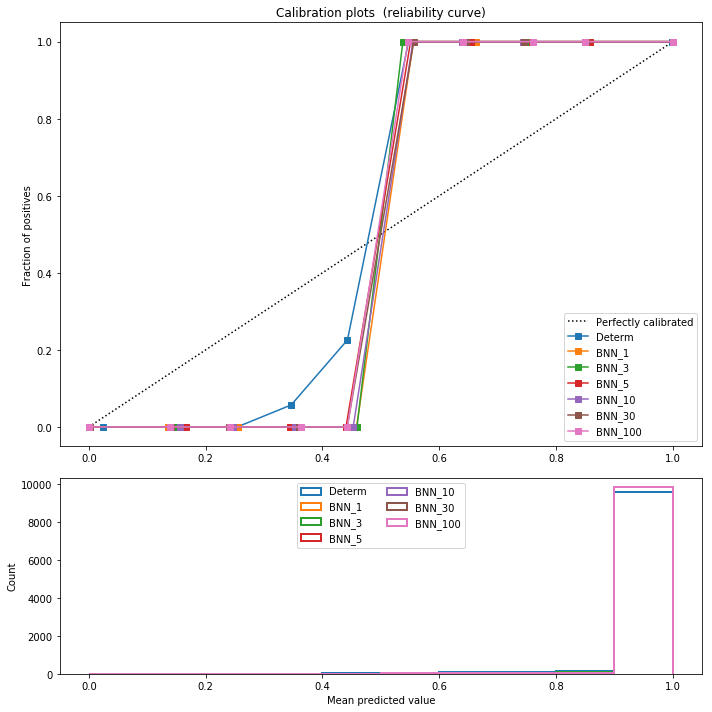

In [95]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

#Determ
correct_predictions = np.argmax(proba_pred_determ, axis=1)==np.argmax(Y_test_determ, axis=1)
proba_associated_to_gt = np.max(proba_pred_determ*Y_test_determ, axis=1)
fraction_of_positives, mean_predicted_value = calibration_curve(correct_predictions, proba_associated_to_gt, n_bins=10)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label='Determ')
ax2.hist(np.max(proba_pred_determ, axis=1), range=(0, 1), bins=10, label='Determ', histtype="step", lw=2)

# BNN
for i,S in enumerate(NUM_SAMPLES):
    correct_predictions = np.argmax(proba_pred_bnn[i], axis=1)==np.argmax(Y_test_bnn[i], axis=1)
    proba_associated_to_gt = np.max(proba_pred_bnn[i]*Y_test_bnn[i], axis=1)
    fraction_of_positives, mean_predicted_value = calibration_curve(correct_predictions, 
                                                                    proba_associated_to_gt, n_bins=10)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label='BNN_{}'.format(NUM_SAMPLES[i]))
    ax2.hist(np.max(proba_pred_bnn[i], axis=1), range=(0, 1), bins=10, 
             label='BNN_{}'.format(NUM_SAMPLES[i]), histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

### Part 6 : Deterministic Dropout vs MC Dropout

In [33]:
class DropoutNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, p=0.1):
        super(DropoutNN, self).__init__()
        self.dropout_p = p
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=self.dropout_p)
        
    def forward(self, x):
        output = F.relu(self.fc1(x))
        output = self.dropout(output)
        output = self.fc2(output)
        output = self.dropout(output)
        return F.log_softmax(output, dim=1)

In [34]:
dropout_model = DropoutNN(28*28, 1024, 10, p=0.1).to(device)
optimizer_dropout = optim.SGD(dropout_model.parameters(), lr=0.01, momentum=0., weight_decay=1e-6)

In [35]:
# Training our deterministic model 
for epoch in range(NUM_EPOCHS):
    loss = 0
    acc = 0
    len_steps = 0
    
    loop = tqdm(train_loader)
    for batch_id, (data, target) in enumerate(loop):
        data, target = data.to(device), target.to(device)
        optimizer_dropout.zero_grad()
        output = dropout_model(data.view(-1,28*28))
        current_loss = F.nll_loss(output, target)
        current_loss.backward()
        loss += current_loss
        optimizer_dropout.step()
        len_steps += len(data)
        
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        acc += pred.eq(target.view_as(pred)).sum().item()

        #update the average loss
        loop.set_description('Epoch {}/{}'.format(epoch + 1, NUM_EPOCHS))
        loop.set_postfix(OrderedDict({'loss':'{:05.3f}'.format(loss / float(len_steps)), 
                                      'acc':'{:05.3f}'.format(acc / float(len_steps))}))
        loop.update()

In [37]:
def uncertainity_estimate(X, model, iters, l2):
    outputs = np.hstack([model(X[:, np.newaxis]).data.numpy() for i in trange(iters)])
    y_mean = outputs.mean(axis=1)
    y_std = np.sqrt(outputs.var(axis=1))
    return y_mean, y_std

In [ ]:
def predict_MCdropout(x, num_s):
    yhats = [torch.exp(dropout_model(x)) for s in num_s]
    mean = torch.mean(torch.stack(yhats), 0)
    y_mean = outputs.mean(axis=1)
    y_std = np.sqrt(outputs.var(axis=1))
    return mean.max(dim = 1)
    output = torch.exp(deterministic_model(x))
    return output.max(dim=1)

In [ ]:
    total = 0
    predicted_for_images = 0
    correct_predictions=0
            
    with torch.no_grad():
        loop = tqdm(test_loader, disable=not verbose)
        for j, (data,labels) in enumerate(loop):
            data, labels = data.to(device), labels.to(device)
            if bnn:
                y = predict_bnn(data.view(-1,28*28), num_s)
            else:
                y = predict_determ(data.view(-1,28*28))
                
            for i in range(len(labels)):
                prob = y[0][i]
                pred = y[1][i]
                if prob>threshold:
                    predicted_for_images+=1
                    correct_predictions += (pred == labels[i]).item()